In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torchvision
import glob
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

SEED=63
np.random.seed(SEED)
torch.manual_seed(SEED)
%cd /content/drive/MyDrive/Denoising Text Image Documents using Autoencoders

/content/drive/MyDrive/Denoising Text Image Documents using Autoencoders


(420, 540, 3)
(420, 540, 3)


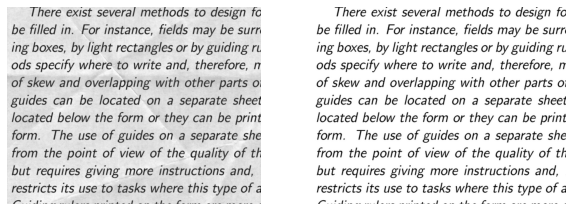

In [ ]:
def show_image(path):
    image=cv2.imread(path)
    print(image.shape)
    plt.imshow(image);
    plt.axis(False);

img_dir='/content/drive/MyDrive/Denoising Text Image Documents using Autoencoders/train/101.png'
img_cleaned_dir='/content/drive/MyDrive/Denoising Text Image Documents using Autoencoders/train_cleaned/101.png'

plt.figure(figsize=(10,4))
plt.subplot(121)
show_image(img_dir)

plt.subplot(122)
show_image(img_cleaned_dir)

In [ ]:
def get_data(path):
    images=[]
    for img_dir in os.listdir(path):
        img_dir=path+'/'+img_dir
        img=cv2.imread(img_dir)
        img=cv2.resize(img, (256,256))
        img = np.reshape(img, img.shape[0]*img.shape[1]*img.shape[2])
        images.append(img)
    return images


X_train=get_data('train')
y_train=get_data('train_cleaned')
X_test=get_data('test')

print('train set size :',len(X_train))
print('test set size  :',len(X_test))

train set size : 144
test set size  : 72


In [ ]:
# Hyperparameters
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = 16

# define transforms
transformations = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

In [ ]:
class ImageSet(Dataset):
    def __init__(self, X, y=None, trans=None):
        self.X=X
        self.y=y
        self.trans=trans

    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        data = np.asarray(data).astype(np.uint8).reshape((256, 256, 3))
        
        if self.trans:
            data = self.trans(data)
            
        if self.y is not None:
            labels = self.y[i][:]
            labels = np.asarray(labels).astype(np.uint8).reshape((256, 256, 3))
            labels = self.trans(labels)
            return (data, labels)
        else:
            return data


train_data=ImageSet(X_train, y_train, transformations)
test_data=ImageSet(X_test, None, transformations)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device
    
device = get_device()
print(device)

cpu


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(3, 512, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  
        self.dec2 = nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2)
        self.dec3 = nn.ConvTranspose2d(128, 256, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(256, 512, kernel_size=2, stride=2)
        self.out = nn.Conv2d(512, 3, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)        
        self.pool = nn.MaxPool2d(2, 2)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = (self.bn1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = (self.bn2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = (self.bn3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = (self.bn4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = (self.bn4(x))
        x = F.relu(self.dec2(x))
        x = (self.bn3(x))
        x = F.relu(self.dec3(x))
        x = (self.bn2(x))
        x = F.relu(self.dec4(x))
        x = (self.bn1(x))
        x = torch.sigmoid(self.out(x))
        return x

In [ ]:
model=Autoencoder()
model.to(device)
print(model)

Autoencoder(
  (enc1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (dec2): ConvTranspose2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec3): ConvTranspose2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(512, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [ ]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
if not os.path.exists('Denoised Images'):
    os.mkdir('Denoised Images')

if not os.path.exists('Denoised Test Images'):
    os.mkdir('Denoised Test Images')

In [ ]:
train_loss = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data in train_loader:
        x = data[0].to(device)
        y = data[1].to(device)
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z,y)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
    
    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    
    if epoch%10==1:
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {loss:.5f}')
        img=z.cpu().data
        name='/content/Denoised Images/denoised_img_'+str(epoch+1)+'.png'
        img = img.view(img.size(0), 3, 256, 256)
        save_image(img, name)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(range(NUM_EPOCHS), train_loss, '-.')
plt.xlabel('Epochs');
plt.ylabel('MSE');

In [ ]:
with torch.no_grad():
    for i, x in enumerate(test_loader):
        x = img.to(device)
        z = model(x)
        img=z.cpu().data
        name='/content/Denoised Test Images/denoised_img_'+str(i)+'.png'
        img = img.view(img.size(0), 3, 256, 256)
        save_image(img, name)

In [1]:
19*50

950